# What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**
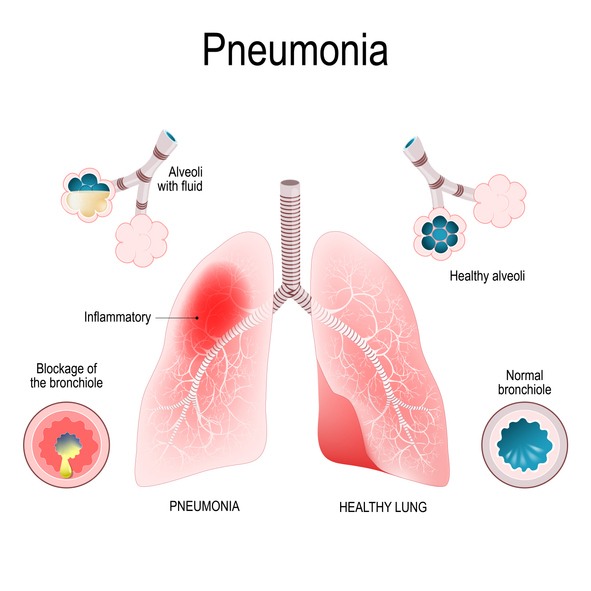

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Importing the necessary libraries

In [2]:
# Core libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(data, dtype=object)

# Loading the Dataset

In [4]:
#from kaggle.api.kaggle_api_extended import KaggleApi

# Create 'data' folder if it doesn't exist
#os.makedirs("data", exist_ok=True)

# Authenticate Kaggle API
#api = KaggleApi()
#api.authenticate()

# Download and unzip the chest x-ray pneumonia dataset
#api.dataset_download_files('paultimothymooney/chest-xray-pneumonia', path='data', unzip=True)

#print("✅ Dataset downloaded and extracted to ./data/")

In [5]:
# TODO: add your own paths here
# train = get_training_data('')
# test = get_training_data('')
# val = get_training_data('')

train = get_training_data('data/chest_xray/train/')
test = get_training_data('data/chest_xray/test/')
val = get_training_data('data/chest_xray/val/')


# Data Visualization & Preprocessing

c:\Users\Gebruiker\anaconda3\envs\pneumonia\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: ylabel='count'>

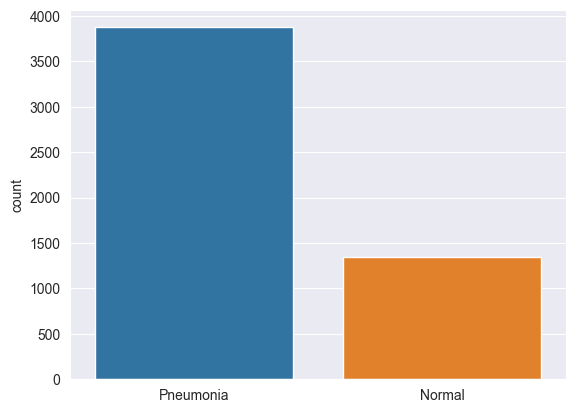

In [6]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(x=l)

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

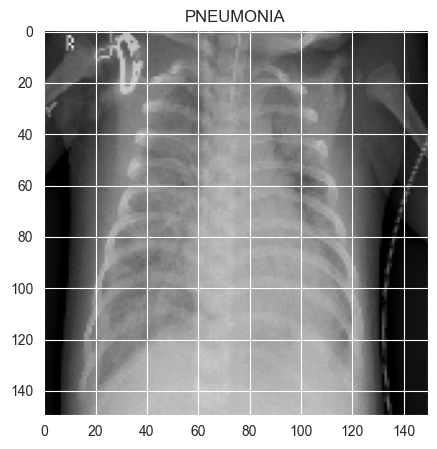

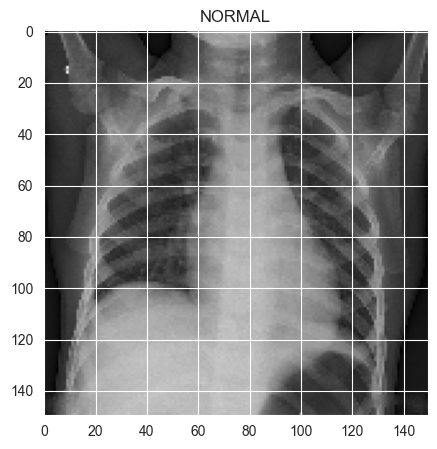

In [7]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [8]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [9]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [10]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [11]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Training the Model

In [12]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [14]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 130s 788ms/step - loss: 0.5590 - accuracy: 0.8344 - val_loss: 30.2907 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 332s 2s/step - loss: 0.2874 - accuracy: 0.8901 - val_loss: 45.1776 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2769 - accuracy: 0.9107
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 126s 774ms/step - loss: 0.2769 - accuracy: 0.9107 - val_loss: 19.2824 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 587s 4s/step - loss: 0.1423 - accuracy: 0.9498 - val_loss: 29.1226 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 0.9544 
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [===================

In [15]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 3s 140ms/step - loss: 0.3607 - accuracy: 0.9119
Loss of the model is -  0.360670268535614
20/20 [==============================] - 3s 141ms/step - loss: 0.3607 - accuracy: 0.9119
Accuracy of the model is -  91.18589758872986 %


# Analysis after Model Training

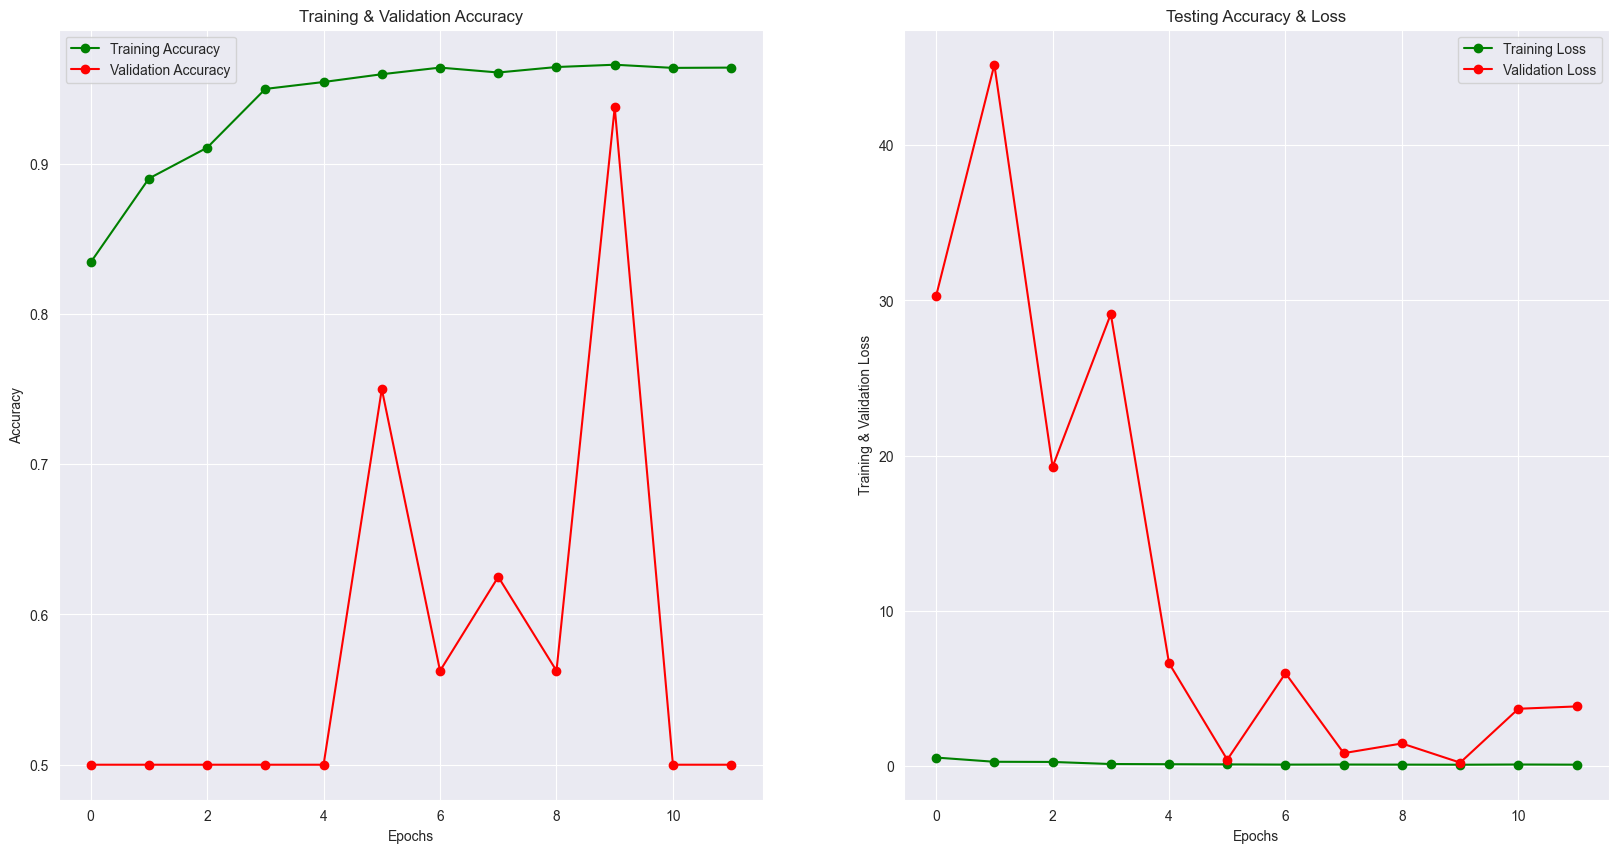

In [16]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [17]:
predictions = model.predict(x_test)
predicted_classes = (predictions > 0.5).astype("int32")
predicted_classes[:15]

20/20 [==============================] - 3s 140ms/step


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [18]:
print(classification_report(y_test, predicted_classes, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.91      0.96      0.93       390
   Normal (Class 1)       0.92      0.83      0.88       234

           accuracy                           0.91       624
          macro avg       0.91      0.90      0.90       624
       weighted avg       0.91      0.91      0.91       624



In [19]:
cm = confusion_matrix(y_test, predicted_classes)
cm


array([[374,  16],
       [ 39, 195]], dtype=int64)

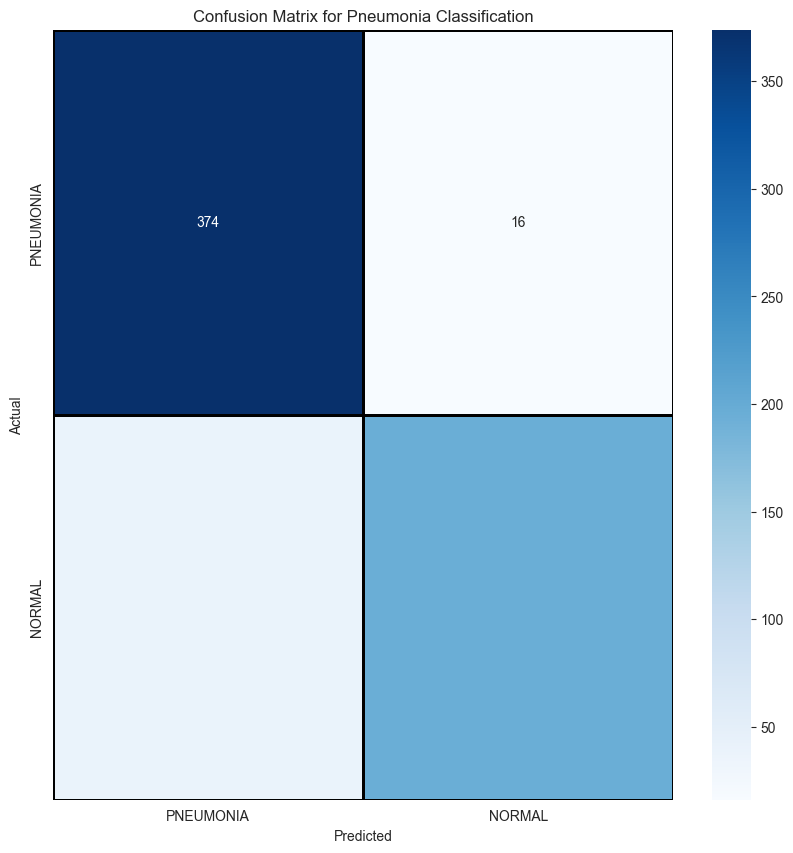

In [20]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1,
         annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Pneumonia Classification")
plt.show()


- There is a bug in the Seaborn library version being used (`0.12.0`), which causes only the top value to be filled in.  
- Unfortunately, the Seaborn library can't be updated since it conflicts with other dependencies.  
- So there is no quick fix for this — only creating the plot in a separate file using the up-to-date Seaborn library.  
- Run `pip install seaborn --upgrade` in a different environment to create a proper plot.


In [21]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

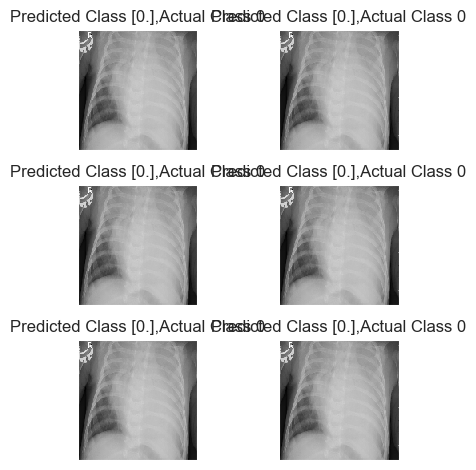

In [22]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

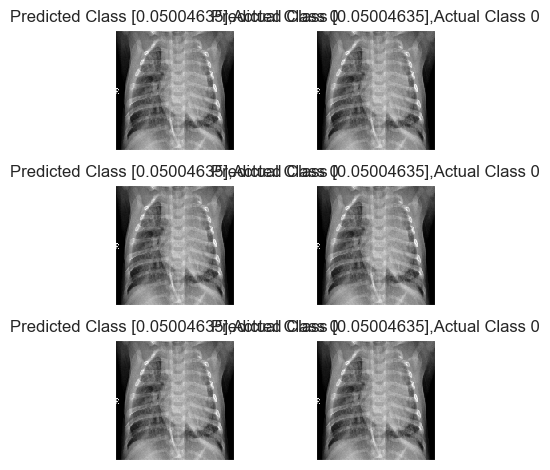

In [23]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

***CNN baseline***

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Path to dataset — update this if needed
base_path = "data/chest_xray/chest_xray"

# Define generators
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_path, 'train'),
    target_size=(150, 150),
    color_mode='grayscale',  # or 'rgb' if using 3-channel input
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(base_path, 'val'),
    target_size=(150, 150),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [25]:
# Train the CNN model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)


Epoch 1/10
163/163 [==============================] - 362s 2s/step - loss: 9.9718 - accuracy: 0.0445 - val_loss: 2.3743 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 131s 799ms/step - loss: 2.5396 - accuracy: 0.2007 - val_loss: 0.6315 - val_accuracy: 0.5625
Epoch 3/10
163/163 [==============================] - 495s 3s/step - loss: 0.6999 - accuracy: 0.6056 - val_loss: 0.8113 - val_accuracy: 0.5625
Epoch 4/10
163/163 [==============================] - 127s 775ms/step - loss: 0.4148 - accuracy: 0.7577 - val_loss: 0.9698 - val_accuracy: 0.5625
Epoch 5/10
163/163 [==============================] - 124s 757ms/step - loss: 0.3290 - accuracy: 0.8299 - val_loss: 1.1698 - val_accuracy: 0.5625
Epoch 6/10
163/163 [==============================] - 124s 759ms/step - loss: 0.2920 - accuracy: 0.8790 - val_loss: 1.2208 - val_accuracy: 0.5625
Epoch 7/10
163/163 [==============================] - 203s 1s/step - loss: 0.2626 - accuracy: 0.9087 - val_loss: 1.4694 - val_accu

In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(base_path, 'test'),
    target_size=(150, 150),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 624 images belonging to 2 classes.


20/20 [==============================] - 8s 360ms/step
              precision    recall  f1-score   support

      NORMAL       0.84      0.13      0.23       234
   PNEUMONIA       0.65      0.98      0.79       390

    accuracy                           0.67       624
   macro avg       0.75      0.56      0.51       624
weighted avg       0.72      0.67      0.58       624



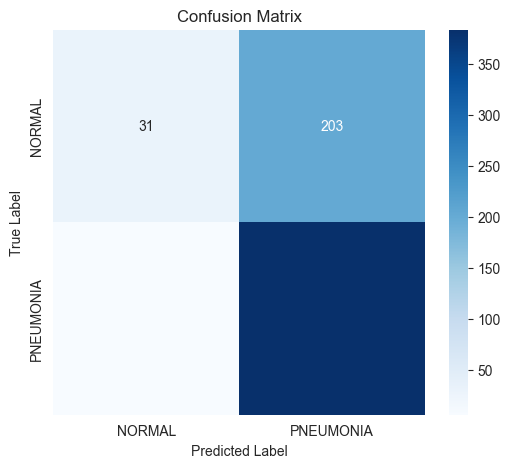

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels on test data
y_true = test_generator.classes
y_prob = model.predict(test_generator)
y_pred = (y_prob > 0.5).astype("int32").reshape(-1)

# Classification report
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [28]:
!pip install keras-tuner --quiet


In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Choice('conv_1_filter', values=[32, 64]),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(150, 150, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(
        filters=hp.Choice('conv_2_filter', values=[64, 128]),
        kernel_size=(3, 3),
        activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'))
    model.add(Dropout(hp.Choice('dropout_rate', values=[0.3, 0.5])))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model


tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='hpo_dir',
    project_name='cnn_bayes_opt'
)

# Start the hyperparameter search
tuner.search(train_generator, epochs=5, validation_data=val_generator)


Trial 3 Complete [00h 11m 27s]
val_accuracy: 0.8125

Best val_accuracy So Far: 0.9375
Total elapsed time: 00h 30m 56s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
32                |32                |conv_1_filter
64                |128               |conv_2_filter
256               |256               |dense_units
0.3               |0.5               |dropout_rate

Epoch 1/5
163/163 [==============================] - 75s 455ms/step - loss: 0.9609 - accuracy: 0.9381 - val_loss: 27.4078 - val_accuracy: 0.5000
Epoch 2/5
163/163 [==============================] - 71s 435ms/step - loss: 0.0857 - accuracy: 0.9709 - val_loss: 32.5571 - val_accuracy: 0.5000
Epoch 3/5
163/163 [==============================] - 74s 456ms/step - loss: 0.0673 - accuracy: 0.9781 - val_loss: 13.2072 - val_accuracy: 0.5625
Epoch 4/5
163/163 [==============================] - 72s 443ms/step - loss: 0.0717 - accuracy: 0.9766 - val_loss: 0.1741 - val_accuracy: 0.8750
Epoch 5/5
120/163

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate on test set
loss, acc = best_model.evaluate(test_generator)
print(f"Bayesian-optimized model accuracy: {acc * 100:.2f}%")
print(f"Test loss: {loss:.4f}")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_prob = best_model.predict(test_generator)
y_pred = (y_prob > 0.5).astype(int).reshape(-1)
y_true = test_generator.classes

# Report
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title("Confusion Matrix – Bayesian Optimized CNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

# Extract features from train set
x_train, y_train = [], []
for i in range(len(train_generator)):
    x, y = train_generator[i]
    for img, label in zip(x, y):
        x_train.append(img.flatten())
        y_train.append(label)
    if len(x_train) >= train_generator.samples:
        break

# Extract features from test set
x_test, y_test = [], []
for i in range(len(test_generator)):
    x, y = test_generator[i]
    for img, label in zip(x, y):
        x_test.append(img.flatten())
        y_test.append(label)
    if len(x_test) >= test_generator.samples:
        break

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

# Optional: Reduce dimensionality
pca = PCA(n_components=100)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train_pca, y_train)

# Predict
y_pred_rf = rf.predict(x_test_pca)

# Report
print("Random Forest (PCA) classification report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
